In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16003, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 16003 (delta 21), reused 20 (delta 13), pack-reused 15967
Receiving objects: 100% (16003/16003), 14.66 MiB | 14.25 MiB/s, done.
Resolving deltas: 100% (10983/10983), done.


In [2]:
pip install kaggle

In [13]:
api_token = {"username":"changmax147","key":"b7c6b9f53feb26d6addd8482c3d3ef44"}
import json
import zipfile
import os

if not os.path.exists("/content/kaggle"):
    os.makedirs("/content/kaggle")

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /content/.kaggle/kaggle.json

if not os.path.exists("/kaggle"):
    os.makedirs("/kaggle")
os.chdir('/kaggle')
!kaggle datasets download -d valentynsichkar/traffic-signs-dataset-in-yolo-format

!ls /kaggle

traffic-signs-dataset-in-yolo-format.zip: Skipping, found more recently modified local copy (use --force to force download)
traffic-signs-dataset-in-yolo-format.zip


In [ ]:
cd yolov5

/content/yolov5


In [ ]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 641.0/641.0 kB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.9 MB/s eta 0:00:00


In [ ]:
import xml.etree.ElementTree as ET
import os
from tqdm import tqdm
import pandas as pd

In [ ]:
input_path = '/content/drive/MyDrive/kaggle'
output_path = '/content/yolov5'

In [ ]:
annotations_path = os.path.join(input_path, 'annotations')
annotations = os.listdir(annotations_path)

In [ ]:
img_name_list = []
width_list = []
height_list = []
label_list = []
xmin_list = []
ymin_list = []
xmax_list = []
ymax_list = []

for idx in tqdm(range(len(annotations))):

    tree = ET.parse(os.path.join(annotations_path, annotations[idx]))
    root = tree.getroot()

    img_name = root.find('filename').text

    size = root.find('size')
    width = size.find('width').text
    height = size.find('height').text

    for group in root.findall('object'):
        label = group.find('name').text
        bbox = group.find('bndbox')
        xmin = bbox.find('xmin').text
        ymin = bbox.find('ymin').text
        xmax = bbox.find('xmax').text
        ymax = bbox.find('ymax').text

        img_name_list.append(img_name)
        width_list.append(width)
        height_list.append(height)
        xmin_list.append(xmin)
        ymin_list.append(ymin)
        xmax_list.append(xmax)
        ymax_list.append(ymax)
        label_list.append(label)


100%|██████████| 877/877 [00:14<00:00, 60.52it/s] 


In [ ]:
labels_df = pd.DataFrame({
                        'img_name': img_name_list,
                        'width': width_list,
                        'height': height_list,
                        'xmin': xmin_list,
                        'ymin': ymin_list,
                        'xmax': xmax_list,
                        'ymax': ymax_list,
                        'label': label_list})
labels_df.head()

,img_name,width,height,xmin,ymin,xmax,ymax,label
0,road0.png,267,400,98,62,208,232,trafficlight
1,road1.png,400,283,154,63,258,281,trafficlight
2,road10.png,400,267,106,3,244,263,trafficlight
3,road111.png,400,267,35,92,101,159,speedlimit
4,road104.png,400,364,48,14,344,345,speedlimit


In [ ]:
!pip install pybboxes

In [ ]:
import numpy as np
import pandas as pd
import os
import pybboxes as pbx
from collections import defaultdict
from tqdm import tqdm
import shutil

In [ ]:
classes = labels_df['label'].unique().tolist()
classes

['trafficlight', 'speedlimit', 'stop', 'crosswalk']

In [ ]:
## Add class number associated to classes
labels_df['class'] = labels_df['label'].apply(lambda x: classes.index(x))
labels_df.head()

,img_name,width,height,xmin,ymin,xmax,ymax,label,class
0,road0.png,267,400,98,62,208,232,trafficlight,0
1,road1.png,400,283,154,63,258,281,trafficlight,0
2,road10.png,400,267,106,3,244,263,trafficlight,0
3,road111.png,400,267,35,92,101,159,speedlimit,1
4,road104.png,400,364,48,14,344,345,speedlimit,1


In [ ]:
## Generate dictionary where key is image_name and value is list of all bboxes inforamtion
img_dict = defaultdict(list)

for idx in tqdm(range(len(labels_df))):
    sample_label_list = []
    img_name = labels_df.loc[idx, 'img_name']
    xmin = labels_df.loc[idx, 'xmin']
    ymin = labels_df.loc[idx, 'ymin']
    xmax = labels_df.loc[idx, 'xmax']
    ymax = labels_df.loc[idx, 'ymax']
    class_num = labels_df.loc[idx, 'class']
    W, H = int(labels_df.loc[idx, 'width']), int(labels_df.loc[idx, 'height'])

    voc_bbox = (int(xmin), int(ymin) ,int(xmax), int(ymax))

    x_center, y_center, w, h = pbx.convert_bbox(voc_bbox, from_type="voc", to_type="yolo", image_size=(W,H))

    sample_label_list.append(str(class_num))
    sample_label_list.append(str(x_center))
    sample_label_list.append(str(y_center))
    sample_label_list.append(str(w))
    sample_label_list.append(str(h))
    line = ' '.join(sample_label_list)

    img_dict[img_name].append(line)


100%|██████████| 1244/1244 [00:00<00:00, 6582.32it/s]


In [ ]:
cd /content/yolov5

/content/yolov5


In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16003, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 16003 (delta 21), reused 20 (delta 13), pack-reused 15967
Receiving objects: 100% (16003/16003), 14.60 MiB | 32.92 MiB/s, done.
Resolving deltas: 100% (10987/10987), done.


In [ ]:
# make labels dir in data folder of yolov5
labels_dir = f'{output_path}/data/labels'
if os.path.exists(labels_dir):
    shutil.rmtree(labels_dir)
os.mkdir(labels_dir)

In [ ]:
## Generate .txt file for each image
for img_name, lines in img_dict.items():
    img_name = img_name.split('.')[0]
    with open(f'{labels_dir}/{img_name}.txt', 'w') as f:
        for line in lines:
            f.write(line)
            f.write('\n')

In [ ]:
import os
import shutil
from random import shuffle

In [ ]:
images_path = input_path + '/images'
labels_path = labels_dir   ## directory having labels in .txt format

In [ ]:
# create train , val folders in data directory of yolov5
train_dir = output_path + '/data/train'
val_dir = output_path + '/data/val'

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)

os.mkdir(train_dir)
os.mkdir(val_dir)

# train, val each containing images and labels folders
os.mkdir(train_dir + '/images')
os.mkdir(train_dir + '/labels')
os.mkdir(val_dir + '/images')
os.mkdir(val_dir + '/labels')


In [ ]:
# Shuffle image file names before splitting into train and val data
files = os.listdir(images_path)
shuffle(files)

In [ ]:
def split(files, ratio):
    elements = len(files)
    middle = int(elements * ratio)
    return [files[:middle], files[middle:]]

def copy_files(images_path, labels_path, destination_path, files):

    for file_name in files:
        file_name = file_name.split('.')[0]

        src = images_path + f'/{file_name}.png'
        dst = destination_path + '/images'
        shutil.copy(src, dst)

        src = labels_path + f'/{file_name}.txt'
        dst = destination_path + '/labels'
        shutil.copy(src, dst)

In [ ]:
images_path, labels_path, train_dir

('/content/drive/MyDrive/kaggle/images',
 '/content/yolov5/data/labels',
 '/content/yolov5/data/train')

In [ ]:
# Split and copy files in train and val folder
train_ratio = 0.75
train_files, val_files = split(files, train_ratio)

root = 'data/traffic_sign_data'

copy_files(images_path, labels_path, train_dir, train_files)
copy_files(images_path, labels_path, val_dir, val_files)

In [ ]:
assert (len(os.listdir(train_dir + '/images')) + len(os.listdir(val_dir + '/images')) == len(os.listdir(images_path)))

**Generate .yaml file**

In [ ]:
with open(f'{output_path}/data/sign_data.yaml', 'w') as f:
    f.write('train: ../data/train/images\n')
    f.write('val: ../data/val/images\n')
    f.write('nc: 4\n')
    f.write(f"names: {classes}")

In [ ]:
epochs = 20
!python train.py --img 640 --batch 16 --epochs {epochs} --data sign_data.yaml --weights yolov5s.pt

train: weights=yolov5s.pt, cfg=, data=sign_data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-226-gdd9e338 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.

In [ ]:
! python detect.py --data sign_data.yaml --weight runs/train/exp/weights/best.pt \
  --source /content/yolov5/data/images/test --iou-thres 0.3 --conf-thres 0.1

detect: weights=['runs/train/exp/weights/best.pt'], source=/content/yolov5/data/images/test, data=sign_data.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.3, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-226-gdd9e338 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/yolov5/data/images/test/test.jpg: 224x640 1 speedlimit, 1 crosswalk, 46.7ms
Speed: 0.3ms pre-process, 46.7ms inference, 2.8ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp3


In [ ]:
! python detect.py --data sign_data.yaml --weights yolov5s.pt --source /content/yolov5/data/images/test --iou-thres 0.45 --conf-thres 0.058

detect: weights=['yolov5s.pt'], source=/content/yolov5/data/images/test, data=sign_data.yaml, imgsz=[640, 640], conf_thres=0.058, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-226-gdd9e338 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
image 1/1 /content/yolov5/data/images/test/test.jpg: 224x640 3 persons, 7 bicycles, 4 cars, 5 traffic lights, 1 backpack, 3 handbags, 43.5ms
Speed: 0.4ms pre-process, 43.5ms inference, 1.5ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp20


In [ ]:
# results stored in runs/train
# get the last stored result
exp = sorted(os.listdir(output_path + '/runs/train'))[-1]
exp_path = output_path + '/runs/train/' + exp

In [ ]:
os.listdir(exp_path)

['val_batch2_pred.jpg',
 'events.out.tfevents.1697102641.2d2333dca375.8018.0',
 'F1_curve.png',
 'train_batch2.jpg',
 'labels.jpg',
 'hyp.yaml',
 'weights',
 'val_batch1_labels.jpg',
 'PR_curve.png',
 'train_batch0.jpg',
 'val_batch2_labels.jpg',
 'val_batch0_labels.jpg',
 'results.csv',
 'R_curve.png',
 'val_batch1_pred.jpg',
 'labels_correlogram.jpg',
 'results.png',
 'val_batch0_pred.jpg',
 'confusion_matrix.png',
 'P_curve.png',
 'opt.yaml',
 'train_batch1.jpg']

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

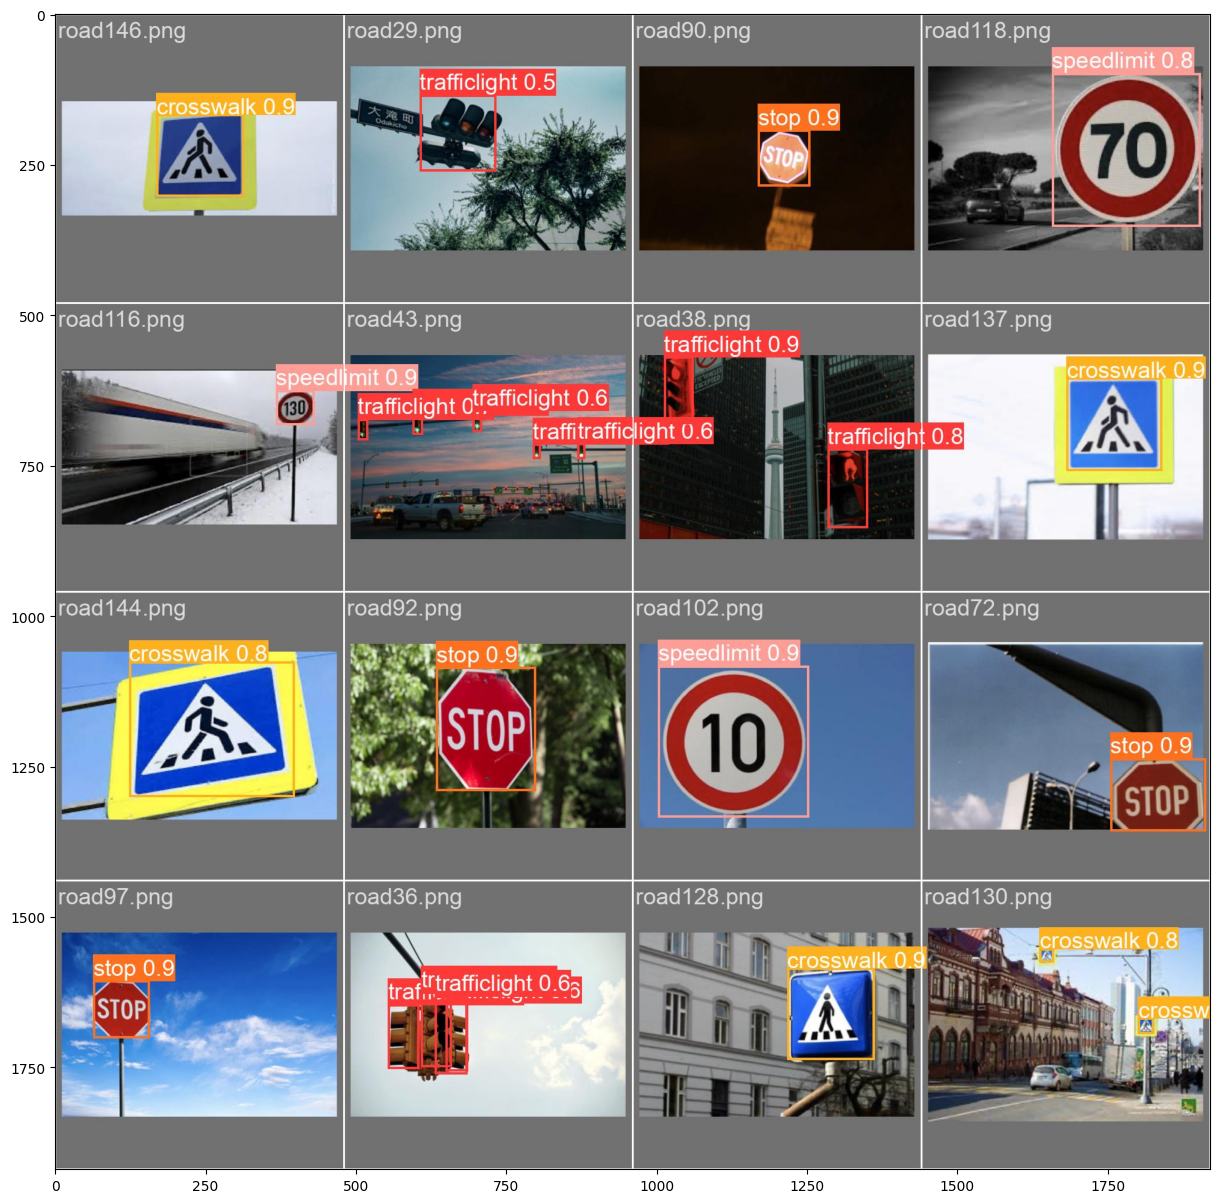

In [ ]:
img_path = exp_path + '/val_batch0_pred.jpg'
img = Image.open(img_path)
plt.figure(figsize=(15, 15))
plt.imshow(img)